In [37]:
import numpy as np
#import pandas as pd 
from keras import utils
from keras import models
from keras import layers
import keras
import matplotlib.pyplot as plt

In [6]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_path = "ships32"
img_size = 32
batch_size = 32

In [99]:
traindata, validdata = utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    validation_split=0.2,
    subset="both",
    seed=1234
)

Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.


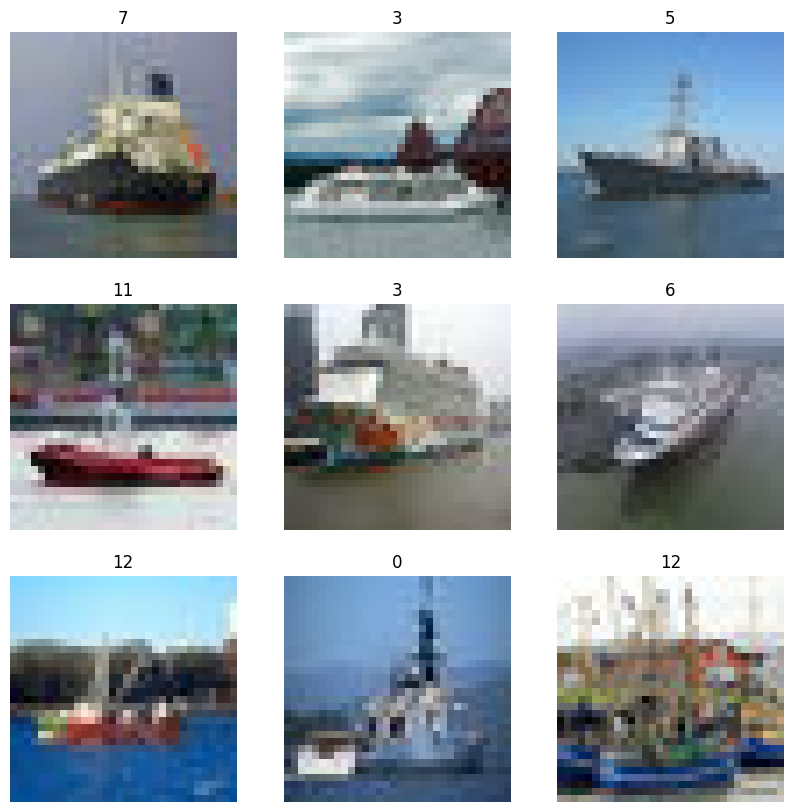

In [100]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

In [106]:
model = models.Sequential()
nfilters = 32
kernel_size = (5,5)
model.add(layers.Conv2D(nfilters, kernel_size, activation= "relu", input_shape=(32,32,3), padding="same"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(nfilters * 2, kernel_size, activation="relu", padding="same"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(nfilters * 4, kernel_size, activation="relu", padding="same"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(len(traindata.class_names), activation="softmax"))
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 13)             │        26,637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,261 (1.09 MB)

 Trainable params: 285,261 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
epochs = 25
lr = 0.001

model.compile(optimizer=keras.optimizers.Adam(lr), loss= keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

model.fit(traindata, epochs=epochs, validation_data=validdata)

#0.6156

Epoch 1/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - categorical_accuracy: 0.1860 - loss: 5.3430 - val_categorical_accuracy: 0.3035 - val_loss: 2.1239
Epoch 2/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - categorical_accuracy: 0.3227 - loss: 2.0486 - val_categorical_accuracy: 0.4256 - val_loss: 1.7563
Epoch 3/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - categorical_accuracy: 0.4328 - loss: 1.7345 - val_categorical_accuracy: 0.4827 - val_loss: 1.5918
Epoch 4/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - categorical_accuracy: 0.4701 - loss: 1.6135 - val_categorical_accuracy: 0.5052 - val_loss: 1.4793
Epoch 5/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - categorical_accuracy: 0.5039 - loss: 1.5056 - val_categorical_accuracy: 0.5279 - val_loss: 1.4182
Epoch 6/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - categorical_accuracy: 0.5196 - loss: 1.4511 - val_categorical_accuracy: 0.5341 - val_loss: 1.4110
Epoch 7/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - categorical_accuracy